## Grad-CAM method for Visualization

Initial input shape: torch.Size([1, 350, 56])
Input shape after permute for conv layers: torch.Size([1, 56, 350])
Shape after conv layer 0: torch.Size([1, 64, 175])
Shape after conv layer 1: torch.Size([1, 64, 87])
Shape after conv layer 2: torch.Size([1, 64, 43])
Shape after conv layer 3: torch.Size([1, 64, 21])
Shape after conv layer 4: torch.Size([1, 64, 10])
Feature maps shape (last conv layer output): torch.Size([1, 64, 10])
Shape before LSTM: torch.Size([1, 10, 64])
Shape after LSTM: torch.Size([1, 10, 64])
Attention output shape: torch.Size([1, 10, 64])
Output shape after FC layer: torch.Size([1, 1])
Initial input shape: torch.Size([1, 350, 56])
Input shape after permute for conv layers: torch.Size([1, 56, 350])
Shape after conv layer 0: torch.Size([1, 64, 175])
Shape after conv layer 1: torch.Size([1, 64, 87])
Shape after conv layer 2: torch.Size([1, 64, 43])
Shape after conv layer 3: torch.Size([1, 64, 21])
Shape after conv layer 4: torch.Size([1, 64, 10])
Feature maps shape (

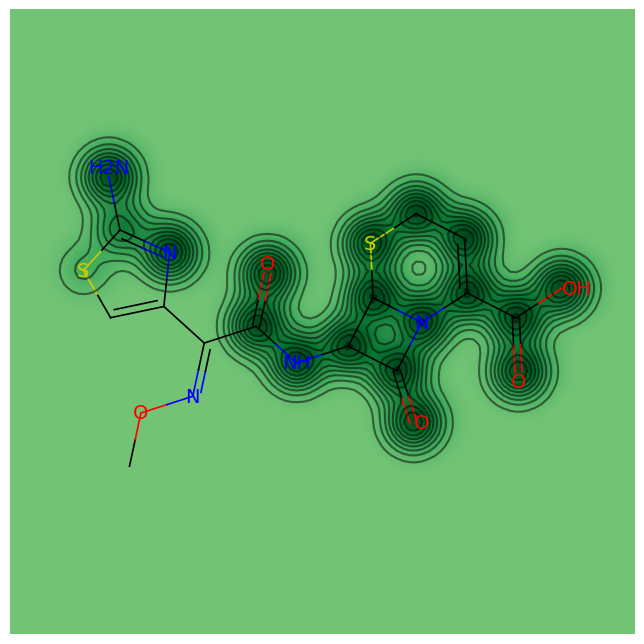

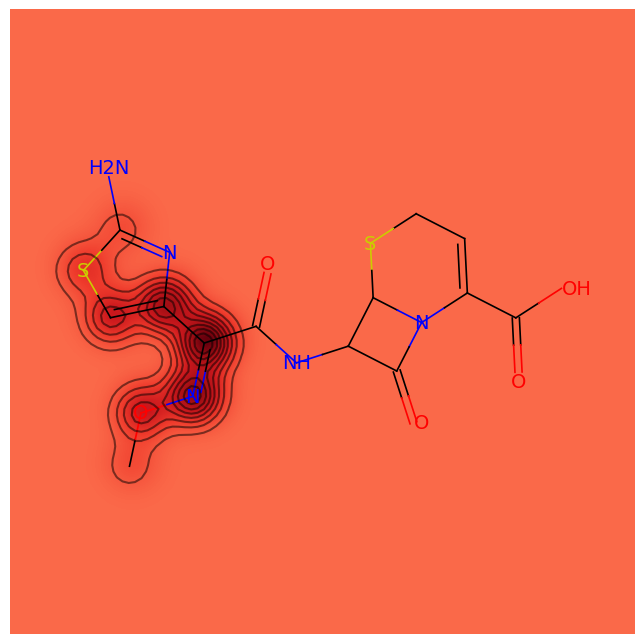

In [11]:
import torch
import numpy as np
from torch.autograd import Function
import torch.nn.functional as F
from model import ConvLSTMCAMbiotic
from data_preprocessing2 import smiles_chars
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.Draw import DrawingOptions
import matplotlib.cm as cm
import matplotlib.colors as cc
import os
import matplotlib.colors as mcolors
from rdkit.Chem.Draw import SimilarityMaps
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from PIL import Image


# Define the functions for removing backgrounds
def remove_background_green(input_image_path, output_image_path):
    image = Image.open(input_image_path)
    image = image.convert("RGBA")
    data = image.getdata()
    new_data = []
    for item in data:
        if item[1] in range(185, 256):  # Targeting the green channel
            new_data.append((255, 255, 255, 255))  # Replace with white
        else:
            new_data.append(item)
    image.putdata(new_data)
    image.save(output_image_path)

def remove_background_red(input_image_path, output_image_path):
    image = Image.open(input_image_path)
    image = image.convert("RGBA")
    data = image.getdata()
    new_data = []
    for item in data:
        if item[0] in range(200, 256):  # Targeting the red channel
            new_data.append((255, 255, 255, 255))  # Replace with white
        else:
            new_data.append(item)
    image.putdata(new_data)
    image.save(output_image_path)

def smiles_to_tensor(smile, char_to_index, maxlen=350):
    """
    Convert a single SMILES string to a PyTorch tensor.
    
    Args:
    - smile (str): The SMILES string to be converted.
    - char_to_index (dict): A dictionary mapping characters to indices.
    - maxlen (int): Maximum length of the sequence to be padded to.
    
    Returns:
    - torch.Tensor: A PyTorch tensor representing the one-hot encoded SMILES.
    """
    # Convert the SMILES string to a one-hot encoded sequence
    encoded = np.zeros((maxlen, len(char_to_index)), dtype=np.int8)
    for i, char in enumerate(smile):
        if i < maxlen:  # Ensure index doesn't exceed maxlen - 1
            if char in char_to_index:
                encoded[i, char_to_index[char]] = 1
        else:
            break  # Break the loop if index equals or exceeds maxlen
    
    # Convert the numpy array to a PyTorch tensor
    encoded_tensor = torch.from_numpy(encoded).unsqueeze(0)  # Add batch dimension
    encoded_tensor = encoded_tensor.to(dtype=torch.float32)  # Model might expect float
    return encoded_tensor

def predict_smiles(model, smiles):
    char_to_index = {char: idx for idx, char in enumerate(smiles_chars)}
    max_len = 350  # Adjust based on your model's input dimensions

    # Ensure the model is in evaluation mode
    model.eval()

    # Convert SMILES to input tensor
    input_tensor = smiles_to_tensor(smiles, char_to_index, max_len).to(model.device)

    with torch.no_grad():
        # Forward pass to get logits
        logits, _, _ = model(input_tensor)
        probabilities = torch.sigmoid(logits).cpu().numpy()
        prediction = (probabilities >= 0.5).astype(int)

    # Output the prediction and probability
    if prediction[0] == 1:
        print(f"{smiles} is predicted to have antibiotic properties with a probability of {probabilities[0][0]:.2f}.")
    else:
        print(f"{smiles} is predicted not to have antibiotic properties with a probability of {1 - probabilities[0][0]:.2f}.")

    return prediction[0], probabilities[0]

class ConvLSTMCAMVisualizerGradCAM:
    def __init__(self, model, device='cpu'):
        # Load the model
        self.model = model
        self.model.eval()  # Set the model to evaluation mode
        self.model.to(device)
        self.device = device

    def prepare_input(self, smiles):
        # Assuming char_to_index is a dictionary mapping SMILES characters to integer indices
        char_to_index = {char: idx for idx, char in enumerate(smiles_chars)}
        smiles_tensor = smiles_to_tensor(smiles, char_to_index, maxlen=350).to(self.device)
        return smiles_tensor

    def grad_cam(self, input_tensor, target_class):
        self.model.eval()  # Ensure the model is in evaluation mode.
        self.model.zero_grad()  # Reset gradients to zero.

        # Enable gradients for the feature maps
        for param in self.model.parameters():
            param.requires_grad = True

        # Perform the forward pass and capture the outputs.
        logits, _, feature_maps = self.model(input_tensor)

        # Enable gradients for the feature maps
        feature_maps.requires_grad_(True)

        # Since we're dealing with binary classification, squeeze the logits to get a scalar.
        logits = logits.squeeze()

        # Determine the class probability and backpropagate.
        if target_class == "positive":
            class_prob = torch.sigmoid(logits)  # Convert logits to probabilities for positive class.
        else:  # Assuming binary classification, "negative" class
            class_prob = 1 - torch.sigmoid(logits)  # Probabilities for negative class.

        # Since class_prob is now a scalar, we can directly backpropagate.
        class_prob.backward()

        # Get the gradients for the feature maps
        gradients = feature_maps.grad.data

        pooled_gradients = torch.mean(gradients, dim=[0, 2], keepdim=True)  # Average over the batch and length dimensions

        # Weight the feature maps with the pooled gradients
        for i in range(feature_maps.size(1)):  # Iterate over the channels
            feature_maps.data[:, i, :] *= pooled_gradients[:, i, :]  # Use the broadcasted multiplication here

        # Generate the heatmap by averaging across the channels
        heatmap = torch.mean(feature_maps.data, dim=1).squeeze()
        heatmap = F.relu(heatmap)  # Apply ReLU to consider only positive influence

        # Normalize the heatmap
        heatmap /= torch.max(heatmap)

        return heatmap.cpu().numpy()

    


   
    def interpolate_heatmap_to_atoms(self, smiles, heatmap): #Adding self to the method signature allows you to call other methods within this method and access class attributes showinng that it is an instance method
        """Interpolate the heatmap to match the number of atoms in the molecule."""
        # Convert SMILES to RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)
        # Get the number of atoms
        num_atoms = mol.GetNumAtoms()

        # Create an interpolation function
        interpolate = interp1d(np.arange(len(heatmap)), heatmap, fill_value="extrapolate")
        
        # Generate new heatmap values that match the number of atoms
        new_heatmap = interpolate(np.linspace(0, len(heatmap) - 1, num_atoms))
        
        return new_heatmap    



    def visualize_molecule_with_heatmap(self, smiles, target_class): #change to "negative" to visualize the heatmap for the negative class
        # Convert SMILES to input tensor
        input_tensor = self.prepare_input(smiles)
        
        # Generate heatmap
        heatmap = self.grad_cam(input_tensor, target_class)
        
        # Interpolate heatmap to match the number of atoms
        interpolated_heatmap = self.interpolate_heatmap_to_atoms(smiles, heatmap)
        
        # Overlay heatmap on molecule and visualize
        self.overlay_heatmap_on_molecule(smiles, interpolated_heatmap)


    def visualize_combined_heatmap(self, smiles, positive_cmap='Greens', negative_cmap='Reds'):
        input_tensor = self.prepare_input(smiles)
        positive_heatmap = self.grad_cam(input_tensor, "positive")
        negative_heatmap = self.grad_cam(input_tensor, "negative")
        interpolated_positive = self.interpolate_heatmap_to_atoms(smiles, positive_heatmap)
        interpolated_negative = self.interpolate_heatmap_to_atoms(smiles, negative_heatmap)
        
        # Generate and save the original heatmap images
        self.overlay_heatmap_on_molecule(smiles, interpolated_positive, 'original_heatmap_positive.png', positive_cmap)
        self.overlay_heatmap_on_molecule(smiles, interpolated_negative, 'original_heatmap_negative.png', negative_cmap)
        
        # Remove backgrounds and save new images
        remove_background_green('original_heatmap_positive.png', 'processed_heatmap_positive.png')
        remove_background_red('original_heatmap_negative.png', 'processed_heatmap_negative.png')


        

    def overlay_heatmap_on_molecule(self, smiles, heatmap, output_image_path, cmap):
        # Convert SMILES to RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)

        # Normalize the heatmap
        norm = Normalize(vmin=min(heatmap), vmax=max(heatmap))

        # Generate and save the similarity map
        fig, ax = plt.subplots()
        fig.patch.set_facecolor('white')
        SimilarityMaps.GetSimilarityMapFromWeights(mol, [norm(value) for value in heatmap], colorMap=plt.get_cmap(cmap), contourLines=10)
        plt.axis('off')
        plt.savefig(output_image_path, bbox_inches='tight')
        plt.close(fig)





if __name__ == "__main__":
    
    model_checkpoint_path = 'Reproducibility_200_epochs/models3/checkpoint-epoch=198-val_loss=0.48.ckpt'# replace with model checkpoint path
    trained_model = ConvLSTMCAMbiotic.load_from_checkpoint(model_checkpoint_path)
    trained_model.eval()  # Set the model to evaluation mode
    visualizer = ConvLSTMCAMVisualizerGradCAM(trained_model, device='cuda' if torch.cuda.is_available() else 'cpu') # Move model to the appropriate device

    # Uncomment the SMILES string you want to visualize
    smiles = "CON=C(C1=CSC(=N1)N)C(=O)NC2C3N(C2=O)C(=CCS3)C(=O)O" # ACTIVE molecule example, change SMILES  to your own molecule
    #smiles = 'CC(C)C1=CC(=O)C(=C(C1c2ccccc2)C(=O)O)C' # INACTIVE molecule example, change SMILES  to your own molecule
    visualizer.visualize_combined_heatmap(smiles, positive_cmap='Greens', negative_cmap='Reds')
    prediction, probability = predict_smiles(trained_model, smiles)





# CAM method

Initial input shape: torch.Size([1, 350, 56])
Input shape after permute for conv layers: torch.Size([1, 56, 350])
Shape after conv layer 0: torch.Size([1, 64, 175])
Shape after conv layer 1: torch.Size([1, 64, 87])
Shape after conv layer 2: torch.Size([1, 64, 43])
Shape after conv layer 3: torch.Size([1, 64, 21])
Shape after conv layer 4: torch.Size([1, 64, 10])
Feature maps shape (last conv layer output): torch.Size([1, 64, 10])
Shape before LSTM: torch.Size([1, 10, 64])
Shape after LSTM: torch.Size([1, 10, 64])
Attention output shape: torch.Size([1, 10, 64])
Output shape after FC layer: torch.Size([1, 1])
Initial input shape: torch.Size([1, 350, 56])
Input shape after permute for conv layers: torch.Size([1, 56, 350])
Shape after conv layer 0: torch.Size([1, 64, 175])
Shape after conv layer 1: torch.Size([1, 64, 87])
Shape after conv layer 2: torch.Size([1, 64, 43])
Shape after conv layer 3: torch.Size([1, 64, 21])
Shape after conv layer 4: torch.Size([1, 64, 10])
Feature maps shape (

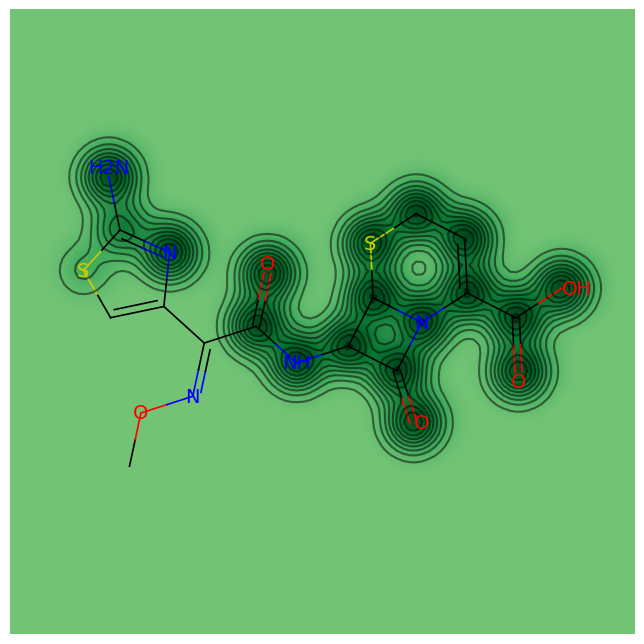

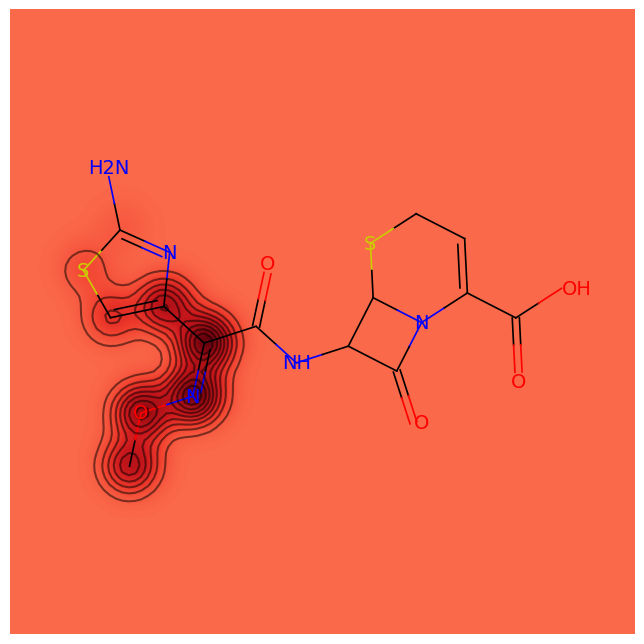

In [12]:
import torch
import numpy as np
from torch.autograd import Function
import torch.nn.functional as F
from model import ConvLSTMCAMbiotic
from data_preprocessing2 import smiles_chars
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from rdkit import Chem
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from PIL import Image
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import MolFromSmiles




def smiles_to_tensor(smile, char_to_index, maxlen=350):
    """
    Convert a single SMILES string to a PyTorch tensor.
    """
    encoded = np.zeros((maxlen, len(char_to_index)), dtype=np.int8)
    for i, char in enumerate(smile):
        if i < maxlen and char in char_to_index:
            encoded[i, char_to_index[char]] = 1
    encoded_tensor = torch.from_numpy(encoded).unsqueeze(0)
    encoded_tensor = encoded_tensor.to(dtype=torch.float32)
    return encoded_tensor

def predict_smiles(model, smiles):
    char_to_index = {char: idx for idx, char in enumerate(smiles_chars)}
    max_len = 350  # Adjust based on your model's input dimensions

    # Ensure the model is in evaluation mode
    model.eval()

    # Convert SMILES to input tensor
    input_tensor = smiles_to_tensor(smiles, char_to_index, max_len).to(model.device)

    with torch.no_grad():
        # Forward pass to get logits
        logits, _, _ = model(input_tensor)
        probabilities = torch.sigmoid(logits).cpu().numpy()
        prediction = (probabilities >= 0.5).astype(int)

    # Output the prediction and probability
    if prediction[0] == 1:
        print(f"{smiles} is predicted to have antibiotic properties with a probability of {probabilities[0][0]:.2f}.")
    else:
        print(f"{smiles} is predicted not to have antibiotic properties with a probability of {1 - probabilities[0][0]:.2f}.")

    return prediction[0], probabilities[0]

class SmilesCAMVisualizer:
    def __init__(self, model, device='cpu'):
        self.model = model
        self.model.eval()
        self.model.to(device)
        self.device = device

    def prepare_input(self, smiles):
        char_to_index = {char: idx for idx, char in enumerate(smiles_chars)}
        smiles_tensor = smiles_to_tensor(smiles, char_to_index, maxlen=350).to(self.device)
        return smiles_tensor

    def forward_pass(self, smiles_tensor):
        output, _, feature_maps = self.model(smiles_tensor)
        return output, feature_maps

    def backward_pass(self, output, target_class="positive"):
        self.model.zero_grad()
        if target_class == "negative":
            negative_output = 1 - output
            negative_output.backward(gradient=torch.ones_like(negative_output), retain_graph=True)
        else:
            output.backward(gradient=torch.ones_like(output), retain_graph=True)
        gradients = self.model.gradients['last_conv']
        return gradients

    def generate_heatmap(self, gradients, feature_maps):
        pooled_gradients = torch.mean(gradients, dim=[0, 2])
        for i in range(feature_maps.size(1)):
            feature_maps[:, i, :] *= pooled_gradients[i]
        heatmap = torch.mean(feature_maps, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)
        heatmap /= np.max(heatmap)
        return heatmap

    def interpolate_heatmap_to_atoms(self, smiles, heatmap):
        mol = Chem.MolFromSmiles(smiles)
        num_atoms = mol.GetNumAtoms()
        interpolate = interp1d(np.arange(len(heatmap)), heatmap, fill_value="extrapolate")
        new_heatmap = interpolate(np.linspace(0, len(heatmap) - 1, num_atoms))
        return new_heatmap
    
        # Define the functions for removing backgrounds
    def remove_background(self, input_image_path, output_image_path, target_class):
        image = Image.open(input_image_path)
        image = image.convert("RGBA")
        data = image.getdata()
        new_data = []

        # Select color range based on the class
        color_range = range(185, 256) if target_class == "positive" else range(200, 256)
        channel_index = 1 if target_class == "positive" else 0

        for item in data:
            # Check if the pixel color is within the specified green or red range
            if item[channel_index] in color_range:
                # Change to white with full transparency
                new_data.append((255, 255, 255, 0))
            else:
                new_data.append(item)
        image.putdata(new_data)
        image.save(output_image_path)
            # Improved diagnostic: check if the image is altered correctly
        processed_image = Image.open(output_image_path)
        if np.array(processed_image).sum() == 0:
            raise ValueError("The processed image is blank after background removal.")

    def visualize_molecule_with_heatmap(self, smiles, target_class="positive"):
        input_tensor = self.prepare_input(smiles)
        output, feature_maps = self.forward_pass(input_tensor)
        gradients = self.backward_pass(output, target_class=target_class)
        original_heatmap = self.generate_heatmap(gradients, feature_maps)
        interpolated_heatmap = self.interpolate_heatmap_to_atoms(smiles, original_heatmap)

        # Determine color map name based on target class
        cmap_name = 'Greens' if target_class == "positive" else 'Reds'
        cmap = plt.get_cmap(cmap_name)

        # Visualize the molecule with the heatmap
        mol = Chem.MolFromSmiles(smiles)
        norm = Normalize(vmin=min(interpolated_heatmap), vmax=max(interpolated_heatmap))
        
        # Create a figure with a white background
        fig, ax = plt.subplots()
        fig.patch.set_facecolor('white')
        
        # Generate the similarity map
        SimilarityMaps.GetSimilarityMapFromWeights(mol, [norm(value) for value in interpolated_heatmap], colorMap=cmap, contourLines=10)
        
        # Remove axes
        plt.axis('off')
        
        # Save the original heatmap image with high DPI
        original_image_path = f'{smiles}_{target_class}_cam.png'
        plt.savefig(original_image_path, bbox_inches='tight', pad_inches=0, dpi=300)
        plt.close(fig)

        # Diagnostic check: Open the image to ensure it's not blank
        saved_image = Image.open(original_image_path)
        if np.array(saved_image).sum() == 0:
            raise ValueError("The saved image is blank.")
        
        # Ensure the image has been saved correctly by re-opening and checking content
        try:
            with Image.open(original_image_path) as img:
                img.verify()  # Verify that it's an image
                if img.mode != "RGBA":
                    raise ValueError("Image saved is not in RGBA mode, which may indicate an issue.")
        except (IOError, ValueError) as e:
            raise ValueError(f"An error occurred verifying the saved image: {e}")

        # Apply background removal
        processed_image_path = f'{smiles}_{target_class}_cam_processed.png'
        self.remove_background(original_image_path, processed_image_path, target_class)



# Sample usage
model_checkpoint = 'Reproducibility_200_epochs/models3/checkpoint-epoch=198-val_loss=0.48.ckpt' # change to model checkpoint path
trained_model = ConvLSTMCAMbiotic.load_from_checkpoint(model_checkpoint)
visualizer = SmilesCAMVisualizer(trained_model, device='cpu')

# Uncomment the SMILES string you want to visualize
smiles = 'CON=C(C1=CSC(=N1)N)C(=O)NC2C3N(C2=O)C(=CCS3)C(=O)O' # ACTIVE molecule example, change to your own molecule
#smiles = 'CC(C)C1=CC(=O)C(=C(C1c2ccccc2)C(=O)O)C' # INACTIVE molecule example, change to your own molecule
visualizer.visualize_molecule_with_heatmap(smiles, target_class="positive")
visualizer.visualize_molecule_with_heatmap(smiles, target_class="negative")
prediction, probability = predict_smiles(trained_model, smiles)


# Difference between both visualization methods
| Feature                  | SmilesCAMVisualizer                                                                                                                | ConvLSTMCAMVisualizerGradCAM                                                                                                                                |
|--------------------------|------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Backward Pass            | Differentiates between "positive" and "negative" target class by altering the gradient signal based on class selection. Uses a single output backward pass method. | Uses a single output backward pass method, but includes additional logic within the `grad_cam` function to adjust gradients based on class probabilities directly. |
| Heatmap Generation       | Generates the heatmap by multiplying pooled gradients with feature maps and then averaging across channels.                        | Generates the heatmap by applying gradients to the feature maps directly, then applying ReLU and averaging across channels. This is done within the `grad_cam` method, which captures the essence of the Grad-CAM technique. |
| Activation Map Concept   | Uses the concept of multiplying pooled gradients with feature maps to emphasize regions of importance for the target class.        | Also utilizes the concept of multiplying gradients with feature maps, but with the additional step of applying ReLU to only consider positive influences, aligning with Grad-CAM principles. |
| Heatmap Normalization    | Normalizes the heatmap by dividing by the maximum value in the heatmap, ensuring all values are between 0 and 1.                  | Similar normalization strategy, dividing the ReLU-activated heatmap by its maximum value to ensure all values are between 0 and 1.                                                                                    |
| Visualization Method     | Uses a single colormap (either 'Greens' for positive or 'Reds' for negative) for overlaying on the molecule.                      | Provides a method (`visualize_combined_heatmap`) to visualize heatmaps for both classes, potentially using different colormaps for positive and negative heatmaps.                                                      |
| Interpolation            | Interpolates the heatmap to match the number of atoms in the molecule using `interp1d`.                                           | Uses the same interpolation strategy to match the heatmap length with the number of atoms, employing `interp1d`.                                                                                                      |
| Overlay Method           | Directly overlays the heatmap on the molecule and saves the image, with the background color of the figure set to white and a high DPI for the saved image. | Directly overlays the heatmap on the molecule, employs a high DPI for saving the image, and sets the figure's background color to white. Additionally, uses `contourLines=10` in `SimilarityMaps.GetSimilarityMapFromWeights`. |
| Background Removal       | Removes the background by targeting specific color ranges and replacing them with transparency. Includes diagnostic checks to ensure the image is altered correctly. | Utilizes two separate functions (`remove_background_green` and `remove_background_red`) for background removal, targeting specific color ranges for transparency.                                                     |
